# Initializing the feature repository

The bash steps can be run here on the notebook. However, **it is important to be always in the `creditscore_feast` folder**. Otherwise, feast commands will not work.

In [2]:
!feast init creditscore_feast
%cd creditscore_feast
!ls

/home/ssierra/.virtualenvs/feast_env/lib/python3.8/site-packages/feast/driver_test_data.py:100: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  for dt in pd.date_range(

Creating a new Feast repository in /home/ssierra/sws_projects/teaching__se4ai/feast/creditscore_feast.

/home/ssierra/sws_projects/teaching__se4ai/feast/creditscore_feast
data  example.py  feature_store.yaml  __init__.py


# Edit `credit_features.py` and apply changes

In [53]:
!feast apply

Updated feature view customer_agg_stats
	ttl: seconds: 604800
 -> seconds: 1814400


No changes to infrastructure


# Create a dataframe using the recently created feature store

In [7]:
from datetime import datetime, timedelta
import pandas as pd

from feast import FeatureStore

end_date_str = '05/10/2022'
end_date = pd.to_datetime(end_date_str)

entity_df = pd.DataFrame.from_dict(
    {
        "id": [1, 2, 5],
        "repayed": [0, 1, 0], # entity_df can be merged with other sources of information
        "event_timestamp": [end_date] * 3,
    }
)

store = FeatureStore(repo_path=".") # Remember to be on the feast repo directory

training_df = store.get_historical_features(
    entity_df=entity_df,
    features=[
        "customer_agg_stats:mean_amount_7d",
        "customer_agg_stats:mean_amount_30d",
        "customer_demographic_features:repayed",
        "customer_demographic_features:age",
    ],
).to_df()

print("----- Feature schema -----\n")
print(training_df.info())

print()
print("----- Example features -----\n")
print(training_df.head())

----- Feature schema -----

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 2
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   id               3 non-null      int64              
 1   repayed          3 non-null      int64              
 2   event_timestamp  3 non-null      datetime64[ns, UTC]
 3   mean_amount_7d   3 non-null      float64            
 4   mean_amount_30d  3 non-null      float64            
 5   repayed__        3 non-null      int64              
 6   age              3 non-null      int64              
dtypes: datetime64[ns, UTC](1), float64(2), int64(4)
memory usage: 192.0 bytes
None

----- Example features -----

   id  repayed           event_timestamp  mean_amount_7d  mean_amount_30d  \
0   1        0 2022-05-10 00:00:00+00:00       20.247768        25.264823   
1   2        1 2022-05-10 00:00:00+00:00       22.661297        19.266338   
2   

In [8]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [11]:
end_date_str = '05/10/2022'
end_date = pd.to_datetime(end_date_str)

store = FeatureStore(repo_path=".")

entity_df = pd.DataFrame.from_dict(
    {
        "id": list(range(100)), # we collect the features for all the 100 custoners
        "event_timestamp": [end_date] * 100,
    }
)

data = store.get_historical_features(
    entity_df=entity_df,
    features=[
        "customer_agg_stats:mean_amount_7d",
        "customer_agg_stats:mean_amount_30d",
        "customer_demographic_features:repayed",
        "customer_demographic_features:age",
        "customer_demographic_features:gender",
        "customer_demographic_features:used_overdraft",
        "customer_demographic_features:have_overdraft",
        "customer_demographic_features:member_since",
    ],
).to_df() # Data can be easily converted to a pandas dataframe


In [12]:
# Do one-hot encoding for dataframe
labenc = LabelEncoder()
data['gender'] = labenc.fit_transform(data['gender'])

In [13]:
# Train model

reg = LogisticRegression(max_iter=1000)

train, test = train_test_split(data, stratify=data['repayed'])

X_train = train.drop(columns=['repayed', 'id', 'event_timestamp'])
y_train = train['repayed']

reg.fit(
    X_train,
    y_train
)

LogisticRegression(max_iter=1000)

In [14]:
# Running on the test set

X_test = test.drop(columns=['repayed', 'id', 'event_timestamp'])
y_test = test['repayed']

y_pred = reg.predict(
    X_test
)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('F1 score: {}'.format(f1))

precision: 0.8571428571428571
recall: 0.6
F1 score: 0.7058823529411764


Text(0.5, 0, 'absolute influence')

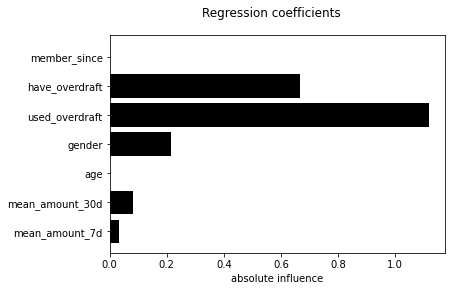

In [15]:
# just for fun, plot the influence of each feature

import matplotlib.pyplot as plt

heights = np.abs(reg.coef_[0])
ticks = X_train.columns

plt.suptitle('Regression coefficients')
plt.barh(ticks, heights, color='black')
plt.xlabel('absolute influence')

# Materializing features

This step is crucial for doing inferences, because it serializes all the features in the feature store. It only serializes what is new from the last time it was run.


In [54]:
# CURRENT_TIME=$(date -u +"%Y-%m-%dT%H:%M:%S")
!feast materialize-incremental {datetime.now().strftime("%Y-%m-%dT%H:%M:%S")}

Materializing 2 feature views to 2022-05-23 04:52:14+02:00 into the sqlite online store.

customer_demographic_features from 2022-05-23 04:49:40+02:00 to 2022-05-23 04:52:14+02:00:
0it [00:00, ?it/s]
customer_agg_stats from 2022-05-02 00:52:14+02:00 to 2022-05-23 04:52:14+02:00:
100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7848.92it/s]


In [55]:
!pwd

/home/ssierra/sws_projects/teaching__se4ai/feast/creditscore_feast


# Doing inference

At inference time, it is desired to have all the features in the feature store. FEAST allows us to quiclly retrieve all the features using `get_online_features()`.

In [56]:
from pprint import pprint
from feast import FeatureStore

store = FeatureStore(repo_path=".")

feature_vector = store.get_online_features(
    features=[
        "customer_agg_stats:mean_amount_7d",
        "customer_agg_stats:mean_amount_30d",
    ],
    entity_rows=[
        # {join_key: entity_value}
        {"id": 10},
        {"id": 35},
    ],
).to_dict()

pprint(feature_vector)

{'id': [10, 35],
 'mean_amount_30d': [16.99458122253418, 20.875102996826172],
 'mean_amount_7d': [16.320850372314453, 7.840512275695801]}


Alternatively, we can declare a Feature Service in the `credit_features.py` file, and use it to decouple feature view definitions and the features needed by end applications.

In [58]:

feature_service = store.get_feature_service("customer_activity")
features = store.get_online_features(
    features=feature_service,
    entity_rows=[
        # {join_key: entity_value}
        {"id": 10},
        {"id": 99},
    ],
).to_dict()

In [59]:
features

{'id': [10, 99],
 'mean_amount_7d': [16.320850372314453, 13.819411277770996],
 'mean_amount_30d': [16.99458122253418, 16.63435173034668]}

# Group exercise

* Your team has requested you to enrich the current model and add new features. You are asked to create new aggregated features in pandas and store them in the feature store.
* You have to create the new features in either the `notebooks/create_features.py` or the `notebooks/1_create_features.ipynb` file.
* Then, you have to modify the `notebooks/creditscore_feast/credit_features.py` file to include the new features.
* Run `feast apply` to apply the changes.
* Train a new model and report the results.


Some ideas:
* Sum all the planned transactions for each customer
* Calculate the sum of amounts for each customer
* Count how many transactions each customer has
* You can do these things for the complete time span or you can restrict it to the last 30, 60 or 90 days.